In [1]:
import numpy as np
import pandas as pd
import re
import random
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.metrics import roc_auc_score
from sklearn.manifold import TSNE, MDS

In [25]:
df = pd.DataFrame(pd.read_csv('musicData.csv'))
random.seed(13240349)
df.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
0,32894.0,Röyksopp,Röyksopp's Night Out,27.0,0.00468,0.652,-1.0,0.941,0.79200,A#,0.115,-5.201,Minor,0.0748,100.889,4-Apr,0.759,Electronic
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.95000,D,0.124,-7.043,Minor,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.01180,G#,0.534,-4.617,Major,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.00253,C#,0.157,-4.498,Major,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.90900,F#,0.157,-6.266,Major,0.0413,145.036,4-Apr,0.323,Electronic


## Data Preprocessing

In [26]:
df.dropna(inplace = True)
df.shape
df = df.loc[df["duration_ms"] != -1]
df = df.loc[df["tempo"] != '?']
encoder = LabelEncoder()
df['key'] = encoder.fit_transform(df['key'])+1
df['mode'] = encoder.fit_transform(df['mode'])
df.head()

,instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
1,46652.0,Thievery Corporation,The Shining Path,31.0,0.01270,0.622,218293.0,0.890,0.950000,6,0.124,-7.043,1,0.0300,115.00200000000001,4-Apr,0.531,Electronic
2,30097.0,Dillon Francis,Hurricane,28.0,0.00306,0.620,215613.0,0.755,0.011800,12,0.534,-4.617,0,0.0345,127.994,4-Apr,0.333,Electronic
3,62177.0,Dubloadz,Nitro,34.0,0.02540,0.774,166875.0,0.700,0.002530,5,0.157,-4.498,0,0.2390,128.014,4-Apr,0.270,Electronic
4,24907.0,What So Not,Divide & Conquer,32.0,0.00465,0.638,222369.0,0.587,0.909000,10,0.157,-6.266,0,0.0413,145.036,4-Apr,0.323,Electronic
6,43760.0,Jordan Comolli,Clash,46.0,0.02890,0.572,214408.0,0.803,0.000008,3,0.106,-4.294,0,0.3510,149.995,4-Apr,0.230,Electronic


## Dimensionality Reduction & Clustering

In [7]:
df_clus = df.copy()
df_clus = df_clus.drop(['instance_id','artist_name','track_name','obtained_date','key','mode'], axis = 1)
stdScale = StandardScaler()
col_norm = df_clus.columns[[0,1,2,3,4,5,6,7,8,9,10]]
normalized_data = stdScale.fit_transform(df_clus.loc[:,col_norm])
df_clus[col_norm] = normalized_data
df_clus['music_genre'] = encoder.fit_transform(df_clus['music_genre'])+1

In [8]:
x = df_clus.drop('music_genre',axis = 1)
y = df.music_genre
p = PCA(n_components = 10)
p.fit(x)
x_transformed = p.transform(x)

In [9]:
tsne = TSNE(n_components=2, perplexity=50, n_jobs=-1).fit_transform(x_transformed)
tsne.shape

(40560, 2)

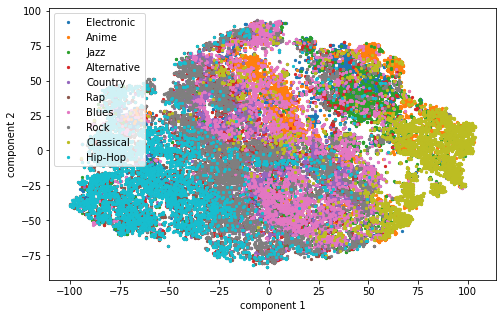

In [23]:
plt.figure(figsize = [8,5])
for label in y.unique():
    x_transformed_filtered = tsne[y == label, :]
    plt.scatter(x_transformed_filtered[:, 0], x_transformed_filtered[:, 1], 
                label=label, s = 5)
plt.legend()
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.show()


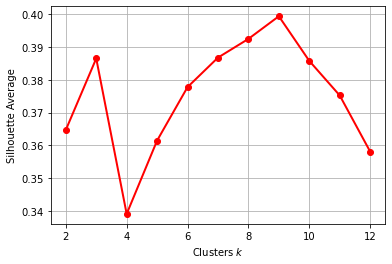

In [11]:
silhouettes = np.zeros(df_clus.shape[1]-1)
for k in range(2, df_clus.shape[1] +1):
    kmeans = KMeans(k, n_init='auto')
    labels = kmeans.fit_predict(tsne)
    silhouettes[k-2] = silhouette_score(tsne, labels)
plt.plot(range(2, df_clus.shape[1]+1), silhouettes, 'r-o', lw = 2)
plt.xlabel(r'Clusters $k$')
plt.ylabel(r'Silhouette Average')
plt.grid()
plt.show()


/Users/hmic/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


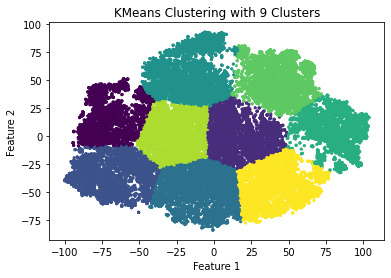

In [13]:
def cluster_and_visualize(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(data) 
    plt.scatter(data[:, 0], data[:, 1], c=kmeans.labels_, cmap='viridis', s=5)
    plt.title(f'KMeans Clustering with {n_clusters} Clusters')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()
    return kmeans
kmeans_model = cluster_and_visualize(tsne, 9)

## Classification

In [15]:
def analyze_genre_data(df, test_size=0.1, random_state=None):

    unique_genres = df['music_genre'].unique()
    train_ = pd.DataFrame()
    test_ = pd.DataFrame()

    for genre in unique_genres:
        genre_data = df[df['music_genre'] == genre]
        train_data, test_data = model_selection.train_test_split(
            genre_data, 
            test_size=test_size, 
            random_state=random_state
        )
        train_ = pd.concat([train_, train_data])
        test_ = pd.concat([test_, test_data])

    features_to_drop = ['music_genre', 'instance_id', 'artist_name', 'track_name', 'obtained_date']
    X_train = train_.drop(features_to_drop, axis=1)
    X_test = test_.drop(features_to_drop, axis=1)
    encoder = LabelEncoder()
    y_train = encoder.fit_transform(train_['music_genre'])
    y_test = encoder.transform(test_['music_genre'])
    genre = pd.DataFrame(unique_genres)

    std_scale = StandardScaler()
    numeric_cols = X_train.select_dtypes(include=['float64', 'int64']).columns
    X_train[numeric_cols] = std_scale.fit_transform(X_train[numeric_cols])
    X_test[numeric_cols] = std_scale.transform(X_test[numeric_cols])

    return X_train, X_test, y_train, y_test, genre
X_train, X_test, y_train, y_test, genre = analyze_genre_data(df)

In [21]:
ada = AdaBoostClassifier(tree.DecisionTreeClassifier(max_depth = 2), 
                         algorithm="SAMME.R", n_estimators=200, learning_rate=0.1)
ada.fit(X_train,y_train)
prediction_prob = ada.predict_proba(X_test)
prediction = ada.predict(X_test)

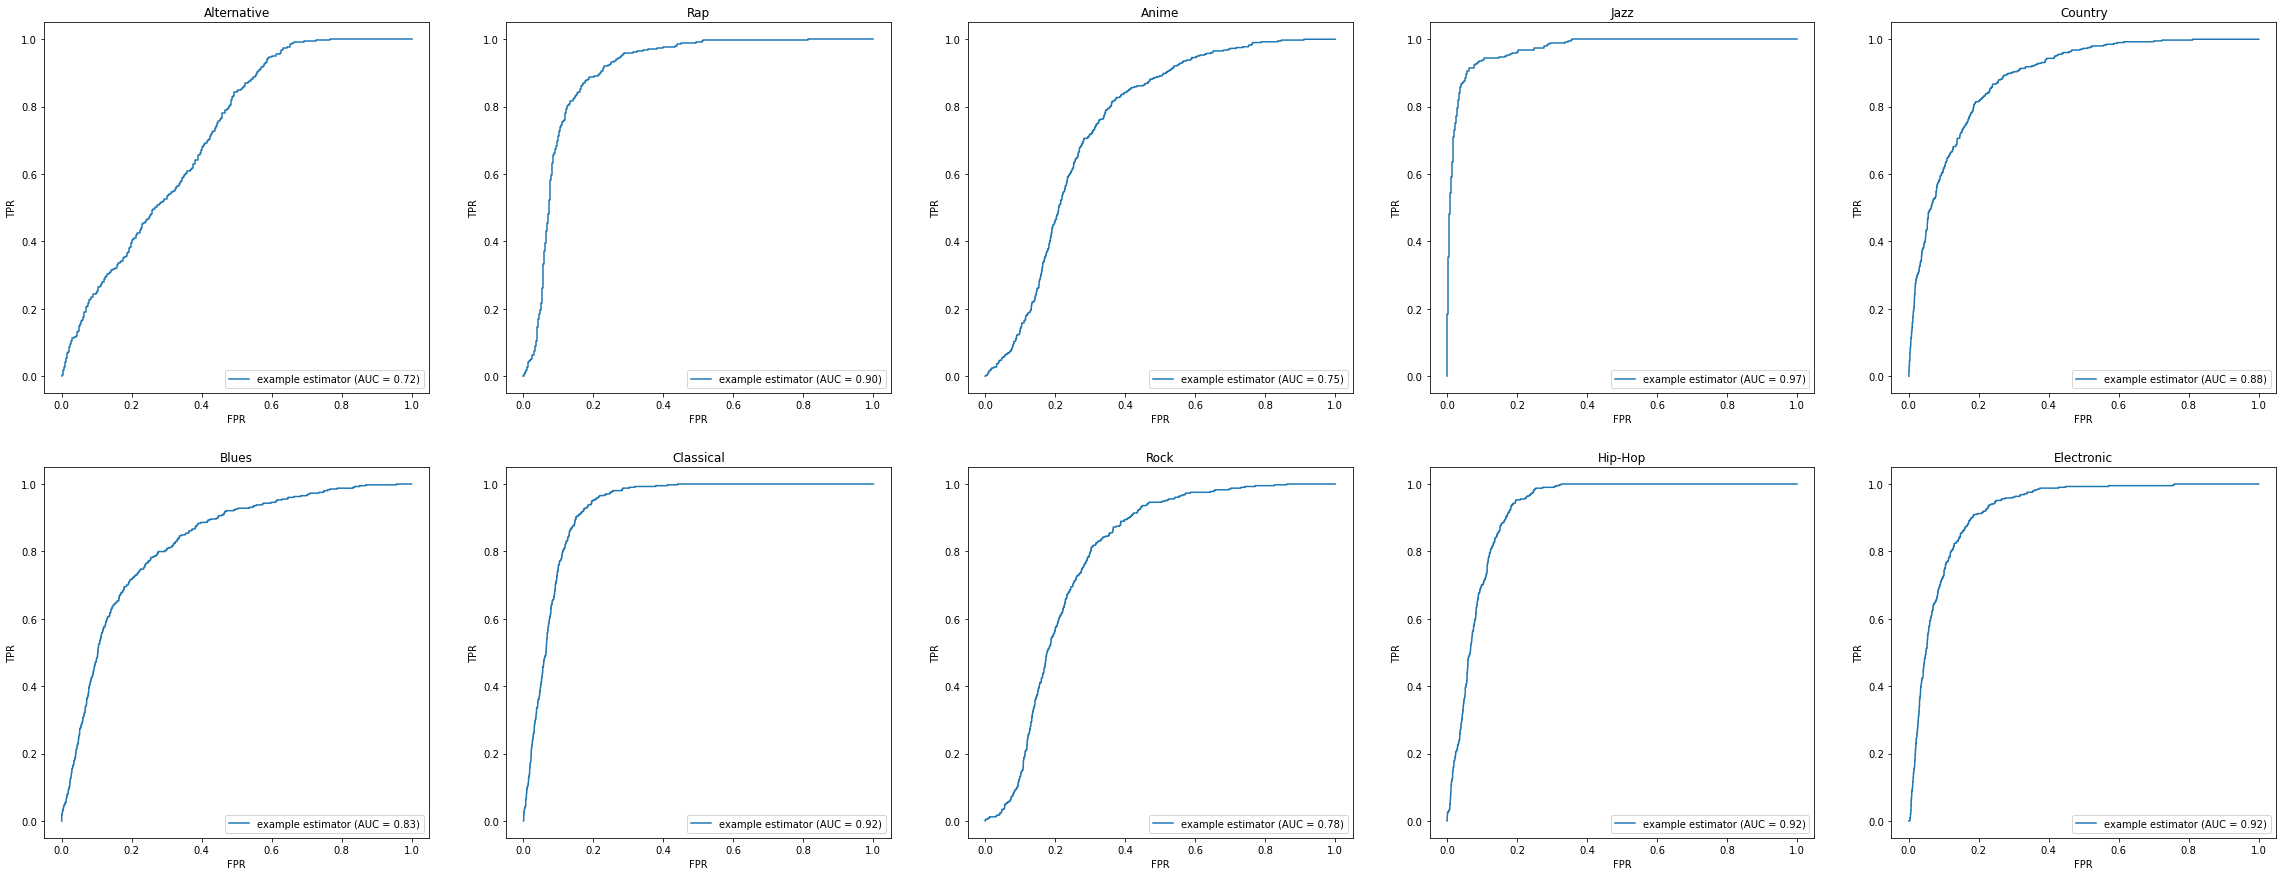

In [32]:
n_classes = prediction_prob.shape[1]
fig, axs = plt.subplots(2, 5, figsize=(40, 15))
axs = axs.flatten()
auc_scores = []
for i, ax in enumerate(axs):
    y_true_class = np.array(y_test == i+1, dtype=int)
    y_pred_class = prediction_prob[:, i]
    auc = roc_auc_score(y_true_class, y_pred_class)
    fpr, tpr, thresholds = metrics.roc_curve(y_true_class, y_pred_class)
    roc_auc = metrics.auc(fpr, tpr)
    roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                 estimator_name='example estimator')
    roc_display.plot(ax=ax)
    ax.set_title(f'{genre[i]}')
    ax.set_xlabel('FPR')
    ax.set_ylabel('TPR')
    ax.legend(loc='lower right')